# Deep AutoEncoders as Pre-Training for Image Classifiers

This network demonstrates the usage of a deep autoencoder for pre-training of an image classifier. The reduction of trraining time and the quality of the results are compared.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

## Load the MNIST Dataset

In [12]:
data = fetch_openml('mnist_784', data_home='./data/mnist/')

In [83]:
X = data['data']
y = data['target']

print("Loaded overall {} images with {} features per image.".format(X.shape[0], X.shape[1]))

Loaded overall 70000 images with 784 features per image.


## Prepare the data

The data is normalized by the maximum pixel value. This step could by using the Keras `ImageDataGenerator` class.

In [84]:
# Normalize the data
X = X.astype('float32') / 255.

## Train/Test Split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [87]:
print("Woring with {} training images and {} test images.".format(len(X_train), len(X_test)))

Woring with 52500 training images and 17500 test images.


## Deep Denoising Autoencoder

In this section, first a deep denoising autoencoder is built and trained. A production model is initialized that does not add Gaussian noise and uses the weights derived during training of the first model.


### Define and train the deep denoising autoencoder

In [204]:
from keras import regularizers

In [340]:
def get_denoising_autoencoder(training=True, sparsity=True):
    """
    Returns a deep denoising autoencoder model.
    INPUT:
        training (boolean): if true, Gaussian noise is applied.
    OUTPUT:
        encoder: Keras model for the encoder
        autoencoder: Keras model for the autoencoder
    """
    n_inputs = 28 * 28 # MNIST
    encoding_dim_1 = 196
    encoding_dim_2 = 49
    decoding_dim_1 = encoding_dim_2
    decoding_dim_2 = encoding_dim_1

    # Input layer
    inputs = layers.Input(shape=(n_inputs,))

    # Add a Gaussian Noise Layer
    inputs_noisy = layers.GaussianNoise(stddev=0.1)(inputs, training=training)

    # Build the Encoder
    reg = None
    name_suffix = ''
    if sparsity:
        reg = regularizers.l2(10e-5)
    
    encoded_1 = layers.Dense(encoding_dim_1, activation='relu',
                                             kernel_regularizer=reg,
                                             name='encoder_1')(inputs_noisy) # 784 -> 300
    encoded_2 = layers.Dense(encoding_dim_2, activation='relu',
                                             kernel_regularizer=reg,
                                             name='encoder_2')(encoded_1) # 300 -> 150

    # Build the Decoder
    decoded_1 = layers.Dense(encoding_dim_1,
                             activation='relu',
                             name='decoder_1')(encoded_2) # 150 -> 300
    decoded_2 = layers.Dense(n_inputs,
                             activation='relu',
                             name='decoder_2')(decoded_1) # 300 -> 784

    # Define the Models
    autoencoder = keras.Model(inputs, decoded_2)
    encoder = keras.Model(inputs, encoded_2)
    
    return encoder, autoencoder

#### Create a standard and a sparse autoencoder model for training

In [341]:
encoder, autoencoder = get_denoising_autoencoder(training=True, sparsity=False)
encoder_sparse, autoencoder_sparse = get_denoising_autoencoder(training=True, sparsity=True)

In [342]:
autoencoder.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
gaussian_noise_19 (GaussianN (None, 784)               0         
_________________________________________________________________
encoder_1 (Dense)            (None, 196)               153860    
_________________________________________________________________
encoder_2 (Dense)            (None, 49)                9653      
_________________________________________________________________
decoder_1 (Dense)            (None, 196)               9800      
_________________________________________________________________
decoder_2 (Dense)            (None, 784)               154448    
Total params: 327,761
Trainable params: 327,761
Non-trainable params: 0
____________________________________________________

In [343]:
encoder.summary()

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
gaussian_noise_19 (GaussianN (None, 784)               0         
_________________________________________________________________
encoder_1 (Dense)            (None, 196)               153860    
_________________________________________________________________
encoder_2 (Dense)            (None, 49)                9653      
Total params: 163,513
Trainable params: 163,513
Non-trainable params: 0
_________________________________________________________________


In [345]:
# Compile the models
opt = keras.optimizers.Adadelta(learning_rate=0.01)
autoencoder.compile(optimizer='Adam',
                      loss='MSE')

autoencoder_sparse.compile(optimizer='Adam',
                      loss='MSE')

In [346]:
# Early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                  min_delta=0,
                                  patience=2,
                                  verbose=0, mode='auto')

In [347]:
# Train the standard autoencoder
history = autoencoder.fit(X_train,
                        X_train,
                        validation_data=(X_test, X_test),
                        callbacks=[es],
                        shuffle=True,
                        epochs=20,
                        batch_size=256)

Train on 52500 samples, validate on 17500 samples
Epoch 1/20
52500/52500 [==============================] - 3s 65us/sample - loss: 0.0339 - val_loss: 0.0182
Epoch 2/20
52500/52500 [==============================] - 3s 56us/sample - loss: 0.0158 - val_loss: 0.0151
Epoch 3/20
52500/52500 [==============================] - 3s 63us/sample - loss: 0.0140 - val_loss: 0.0138
Epoch 4/20
52500/52500 [==============================] - 3s 57us/sample - loss: 0.0131 - val_loss: 0.0132
Epoch 5/20
52500/52500 [==============================] - 3s 60us/sample - loss: 0.0126 - val_loss: 0.0126
Epoch 6/20
52500/52500 [==============================] - 3s 60us/sample - loss: 0.0122 - val_loss: 0.0123
Epoch 7/20
52500/52500 [==============================] - 3s 62us/sample - loss: 0.0119 - val_loss: 0.0120
Epoch 8/20
52500/52500 [==============================] - 3s 62us/sample - loss: 0.0117 - val_loss: 0.0119
Epoch 9/20
52500/52500 [==============================] - 3s 63us/sample - loss: 0.0114 - val_

In [348]:
# Train the sparse autoencoder
history_sparse = autoencoder_sparse.fit(X_train,
                                        X_train,
                                        validation_data=(X_test, X_test),
                                        callbacks=[es],
                                        shuffle=True,
                                        epochs=20,
                                        batch_size=256)

Train on 52500 samples, validate on 17500 samples
Epoch 1/20
52500/52500 [==============================] - 5s 90us/sample - loss: 0.0453 - val_loss: 0.0253
Epoch 2/20
52500/52500 [==============================] - 4s 74us/sample - loss: 0.0226 - val_loss: 0.0212
Epoch 3/20
52500/52500 [==============================] - 4s 75us/sample - loss: 0.0201 - val_loss: 0.0196
Epoch 4/20
52500/52500 [==============================] - 4s 74us/sample - loss: 0.0189 - val_loss: 0.0188
Epoch 5/20
52500/52500 [==============================] - 4s 76us/sample - loss: 0.0182 - val_loss: 0.0183
Epoch 6/20
52500/52500 [==============================] - 4s 76us/sample - loss: 0.0176 - val_loss: 0.0176
Epoch 7/20
52500/52500 [==============================] - 4s 74us/sample - loss: 0.0172 - val_loss: 0.0173
Epoch 8/20
52500/52500 [==============================] - 4s 73us/sample - loss: 0.0169 - val_loss: 0.0169
Epoch 9/20
52500/52500 [==============================] - 4s 71us/sample - loss: 0.0166 - val_

#### Plot the training curve

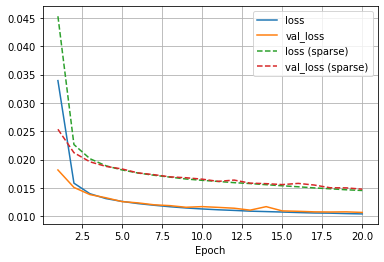

In [349]:
# Plot the training curve
n_epochs = len(history.history['loss'])

plt.plot(range(1,n_epochs+1), history.history['loss'], label='loss')
plt.plot(range(1,n_epochs+1), history.history['val_loss'], label='val_loss')

plt.plot(range(1,n_epochs+1), history_sparse.history['loss'], label='loss (sparse)', linestyle='--')
plt.plot(range(1,n_epochs+1), history_sparse.history['val_loss'], label='val_loss (sparse)', linestyle='--')

plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()

The sparsity constraint leads to a slower convergence of the training.

#### Save the trained autoencoder and encoder

In [352]:
keras.models.save_model(autoencoder, './models/autoencoder')
keras.models.save_model(encoder, './models/encoder')

INFO:tensorflow:Assets written to: ./models/autoencoder/assets
INFO:tensorflow:Assets written to: ./models/encoder/assets


In [353]:
keras.models.save_model(autoencoder_sparse, './models/autoencoder_sparse')
keras.models.save_model(encoder_sparse, './models/encoder_sparse')

INFO:tensorflow:Assets written to: ./models/autoencoder_sparse/assets
INFO:tensorflow:Assets written to: ./models/encoder_sparse/assets


#### Visualize the reconstruction error on the trained model

Here, the Gaussian Noise is still turned on.

In [354]:
%matplotlib inline
import matplotlib.pyplot as plt

In [374]:
def plot_results(y_trues, y_preds_list):
    """
    Creates a plot to compare the original and the reconstructed image.
    INPUT:
        y_trues: array of 28x28 original MNIST images
        y_preds: array of 28x28 reconstructed MNIST images
    OUTPUT:
        NONE:
    """

    fig = plt.figure(figsize=(20,3))
    columns = len(y_trues)
    rows = len(y_preds_list) + 1


    # Plot ground truth images
    for i, img in enumerate(y_trues):
        fig.add_subplot(rows, columns, 1+i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    for i, y_preds in enumerate(y_preds_list):
        assert len(y_trues) == len(y_preds)
        # Plot predicted images
        for j, img in enumerate(y_preds):
            
            fig.add_subplot(rows, columns, 1 + len(y_trues) + i*len(y_trues) + j)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
    
    plt.show()

In [375]:
n_predictions = 20

y_trues = X_train[:n_predictions].reshape((-1,28,28))
y_preds = autoencoder.predict(X_train[:n_predictions]).reshape((-1,28,28))
y_preds_sparse = autoencoder_sparse.predict(X_train[:n_predictions]).reshape((-1,28,28))

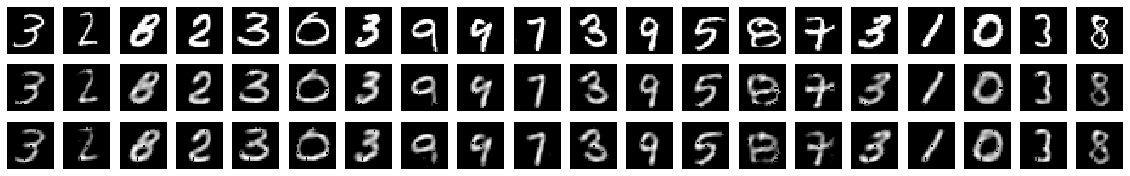

In [376]:
plot_results(y_trues, [y_preds, y_preds_sparse])

The first row shows the original images, the second row the reconstructions of the standard autoencoder and the third row the reconstruction of the sparse autoencoder. For the sparse autoencoder, the slightly higher validation loss during training reflects itself in more blurry reconstructions of the images.

#### Plot the weights learned by the encoder (latent features)

In [328]:
def plot_weights_matrix(model, layer_name, n_neurons):
    """
    Plots the weight matrix of the first `n_neurons` neurons of a layer in the given model.
    
    The kernel of the given layer has dimensions input_shape x output_shape. We slice this
    matrix by the axis of the output_shape and display each of the slices reshaped to a quadratic
    picture.
    
    INPUT:
        model: A trained Keras model
        layer_name (string): name of the layer whose weight matrix shall be shown
        n_neurons (int): number of neurons to be visualized
    """
    kernel_eval = K.eval(model.get_layer(layer_name).kernel)
    
    # dimension for weight matrix plot
    dim = int(np.sqrt(kernel_eval.T[0].shape)[0])
    
    # plot the first n_neurons neurons
    fig = plt.figure(figsize=(n_neurons, 4))
    for i in range(n_neurons):
        plt.subplot(1, n_neurons, i + 1)
        plt.imshow(kernel_eval.T[i].reshape(dim, dim), cmap='gray')
        plt.axis('off')
    plt.show()

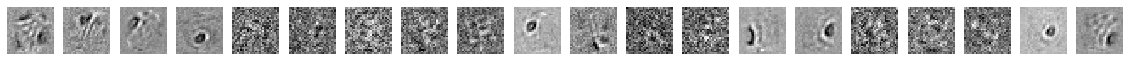

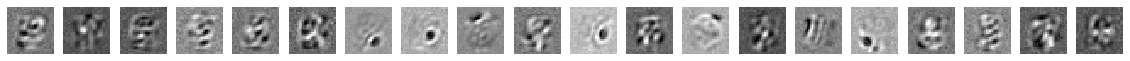

In [379]:
# Visualize some learned features of the first encoding layer
plot_weights_matrix(autoencoder, 'encoder_1', 20)

# Visualize some learned features of the first encoding layer
plot_weights_matrix(autoencoder_sparse, 'encoder_1', 20)


The upper row shows the learned features for the standard autoencoder, the lower one for the sparse autoencoder. While the standard autoencoder contains more noisier neurons, the standardized autoencoder shows sharper, pattern-based activations for the neurons.

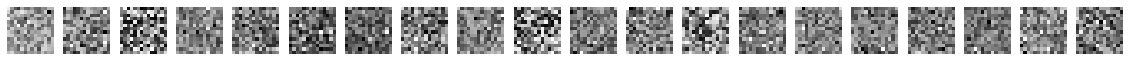

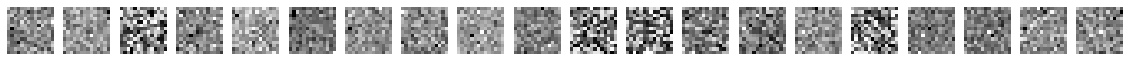

In [380]:
# Visualize some learned features of the second encoding layer
plot_weights_matrix(autoencoder, 'encoder_2', 20)

# Visualize some learned features of the second encoding layer
plot_weights_matrix(autoencoder_sparse, 'encoder_2', 20)

In [381]:
# Kernel sparsity of the encoding, i.e. average weight
encoder_eval = encoder.predict(X_test[:256])
encoder_avg_sparsity = np.mean(np.sqrt(np.sum(np.square(sample_eval), axis=1)))

encoder_sparse_eval = encoder_sparse.predict(X_test[:256])
encoder_sparse_avg_sparsity = np.mean(np.sqrt(np.sum(np.square(encoder_sparse_eval), axis=1)))

print("Average sparsity {} of encodings in the standard autoencoder.".format(encoder_avg_sparsity))
print("Average sparsity {} of encodings in the sparse autoencoder.".format(encoder_sparse_avg_sparsity))

Average sparsity 18.715654373168945 of encodings in the standard autoencoder.
Average sparsity 3.2995221614837646 of encodings in the sparse autoencoder.


The sparsity in the produced encodings is reduced by nearly a factor of 6 when applying regularization to the encoding layers.

### Create the productive encoder model without Gaussian noise

This model will be used by the image classifier.

In [80]:
# Create a new instance of the encoder with turned off Gaussian noise
prod_encoder, prod_autoencoder = get_denoising_autoencoder(training=False)

# Copy the weights from the trained encoder
prod_encoder.set_weights(encoder.get_weights())
prod_autoencoder.set_weights(autoencoder.get_weights())

# Print a summary
prod_encoder.summary()
prod_autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_17 (Dense)             (None, 150)               45150     
Total params: 280,650
Trainable params: 280,650
Non-trainable params: 0
_________________________________________________________________
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
____________________________________

Create predictions with the productive deep autoencoder (Gaussian noise turned off).

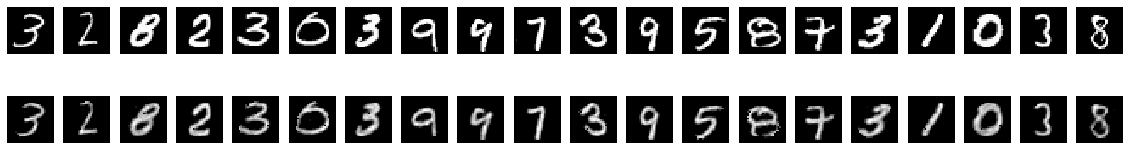

In [81]:
n_predictions = 20

y_preds = prod_autoencoder.predict(X_train[:n_predictions]).reshape((-1,28,28))
y_trues = X_train[:n_predictions].reshape((-1,28,28))

plot_results(y_trues, y_preds)

Obviously, the images loose sharpness when being reconstructed by the autoencoder.